In [7]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout, Activation

from preprocess import get_data, extract_samples_from_rows, create_aug_img_pipeline, plot_data, plot_img, change_settings, generate_batch, settings




In [8]:
change_settings(
    P_DROP_ZERO = 0.0,
    #DROP_ZERO_HISTORY_LIM = 0,
    SHUFFLE = True,
    CHOOSE_ALL_CAMERAS = True,
    DO_FILTER = False,
    DO_FLIP = True,
    P_FILTER = 0.98,
    FILTER_BIN_SIZE = 0.01,
    FILTER_BIN_TAKE_ABS = True,
)

data, count = get_data()

flipping is set to True
extracted 414 samples from track1.
extracted 48216 samples from data_ori.
0 samples dropped based on 00 rules
extracted 48630 samples total.


(-0.94269539999999996, 2)
8730
-1.0


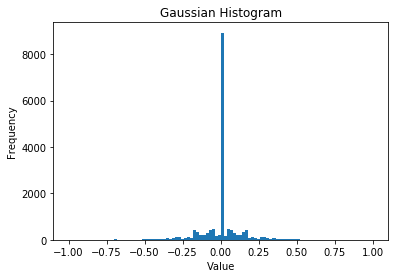

In [3]:
images_un, steers_un = extract_samples_from_rows(data, fake=True)

stats = list(zip(*np.unique(steers, return_counts=True)))
count_dict = dict(stats)
mx_count = max(stats, key=lambda x: x[1])[1]
mx_value = max(stats, key=lambda x: abs(x[0]))[0]
print (stats[1])
print(mx_count)
print (mx_value)
stats = sorted(stats, key=lambda x: x[1])
#print (stats)
#print (sorted(stats, key=lambda x: abs(x[0])))

[0.90, 0.00]
[0, 1.15]
[292, 1]
#abs(value) = [0, 1.15]

plot_data (steers)

301
[(0.85000010000000004, 6), (0.92374369999999995, 1), (0.93323809999999996, 1), (0.94269539999999996, 2), (1.0, 8)]


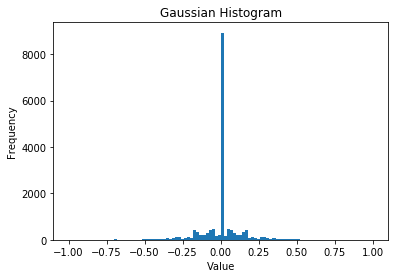

In [8]:
stats_un = list(zip(*np.unique(steers_un, return_counts=True)))
print(len(stats_un))
print(sorted(stats_un)[-5:])
plot_data (steers_un)

In [9]:
print (stats[-5:])
print(len(data))

[(6.1424564265297947, 1), (6.3513295989198326, 1), (6.8212510119804106, 1), (7.1051989314700732, 1), (0.0, 12)]
16210


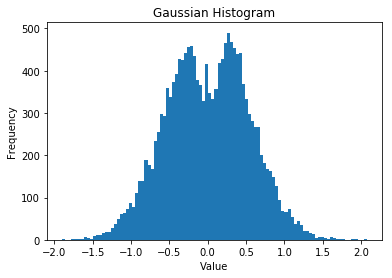

In [4]:
g = generate_batch(data, fake=True, augment=True, flipit=False, rand_camera=False)

images, steers = [], []

for el in g:
    images.extend(el[0])
    steers.extend(el[1])
    if len(images) >= count:
        break

#images, steers = extract_samples_from_rows(data, [0, 1, 2], [0, -0.15, 0.15], fake=True, )#rand=True)


plot_data(steers)



16210
16210


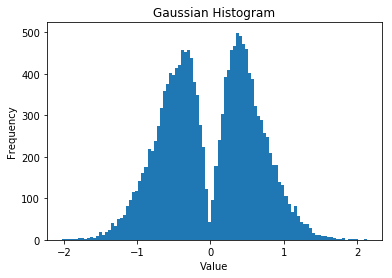

In [5]:

print (len(steers))
change_settings(
    AUGMENT_IMAGES=True, 
    SHEAR_SIGMA=settings["SHEAR_RANGE"][1]/4, 
    SHEAR_ATAN_CORRECTION=20, 
    P_KEEP_ZERO=0.001,
    DROP_ZERO_HISTORY_LIM=1,
)

aug_image = create_aug_img_pipeline(fake=True)
images_a, steers_a = zip(*list(map(aug_image, images, steers)))
print (len(steers))
plot_data(steers_a)
#plot_img(images_a[0])
#plot_img(images[0])
#print (images_a[0].shape)

In [ ]:
plot_img(images_a[5])

16210  :: gotten total data amount ::  16210
20  :: rows


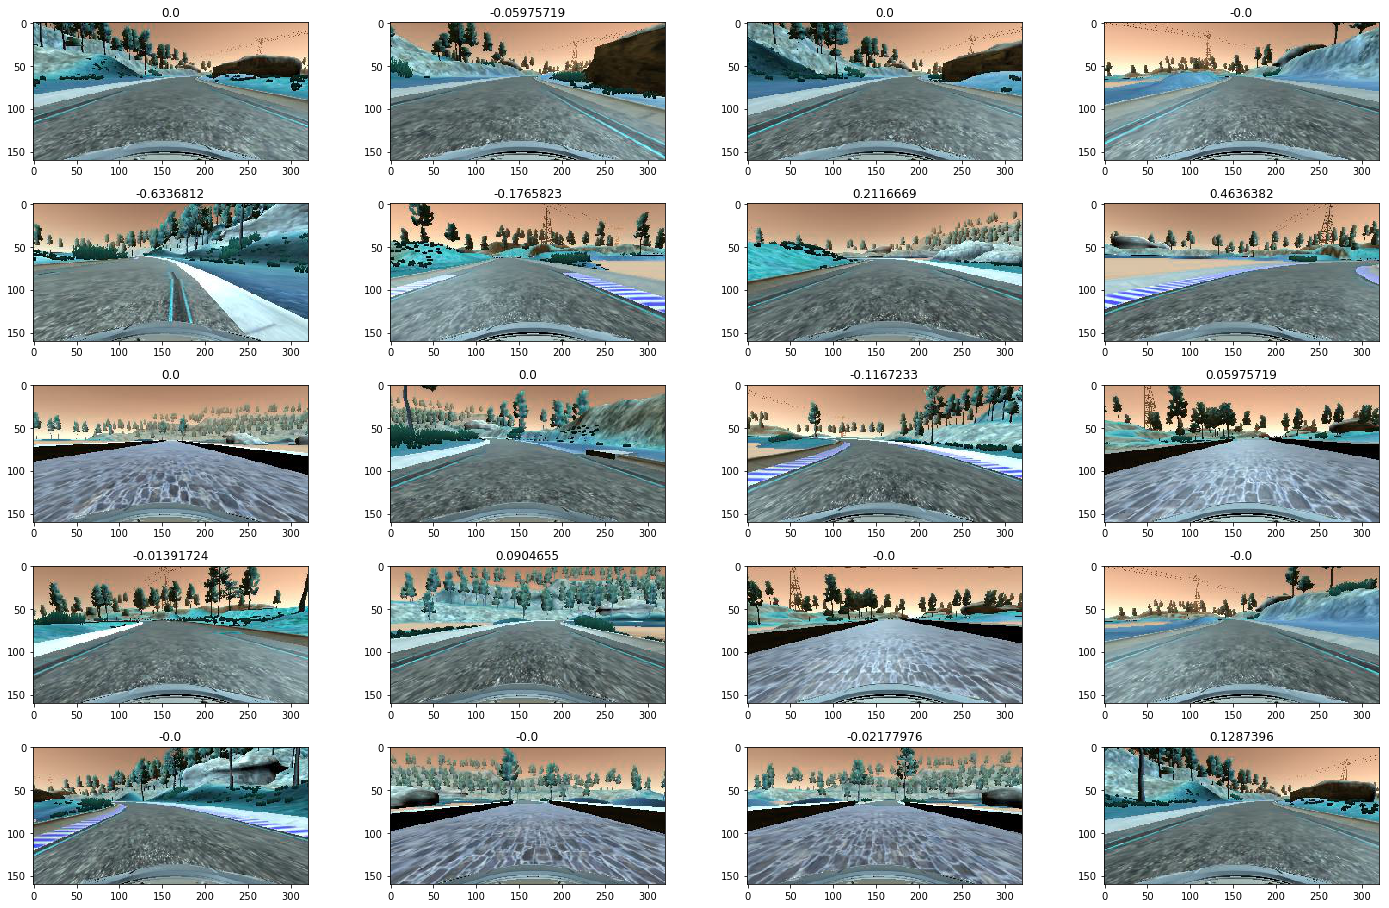

In [8]:
import random

i_st = random.randint(100, 3000)

data_pl = data[i_st:i_st+20]
print (len(data_pl), " :: rows")
images, steers = extract_samples_from_rows(data_pl, fake=False, augment=False)

change_settings(
    DO_FILTER = False
)

# Image augmentations effects visualization

fig = plt.figure(figsize=(20, 15))

for i, el in enumerate(zip(images, steers)):
    img, angle = el
    a=fig.add_subplot(len(images)//4+1,4,(i+1))
    imgplot = plt.imshow(img)
    a.set_title(str(angle))
plt.tight_layout()

### Displaying images with the results from the augmentation pipeline for visalization 

20  :: rows


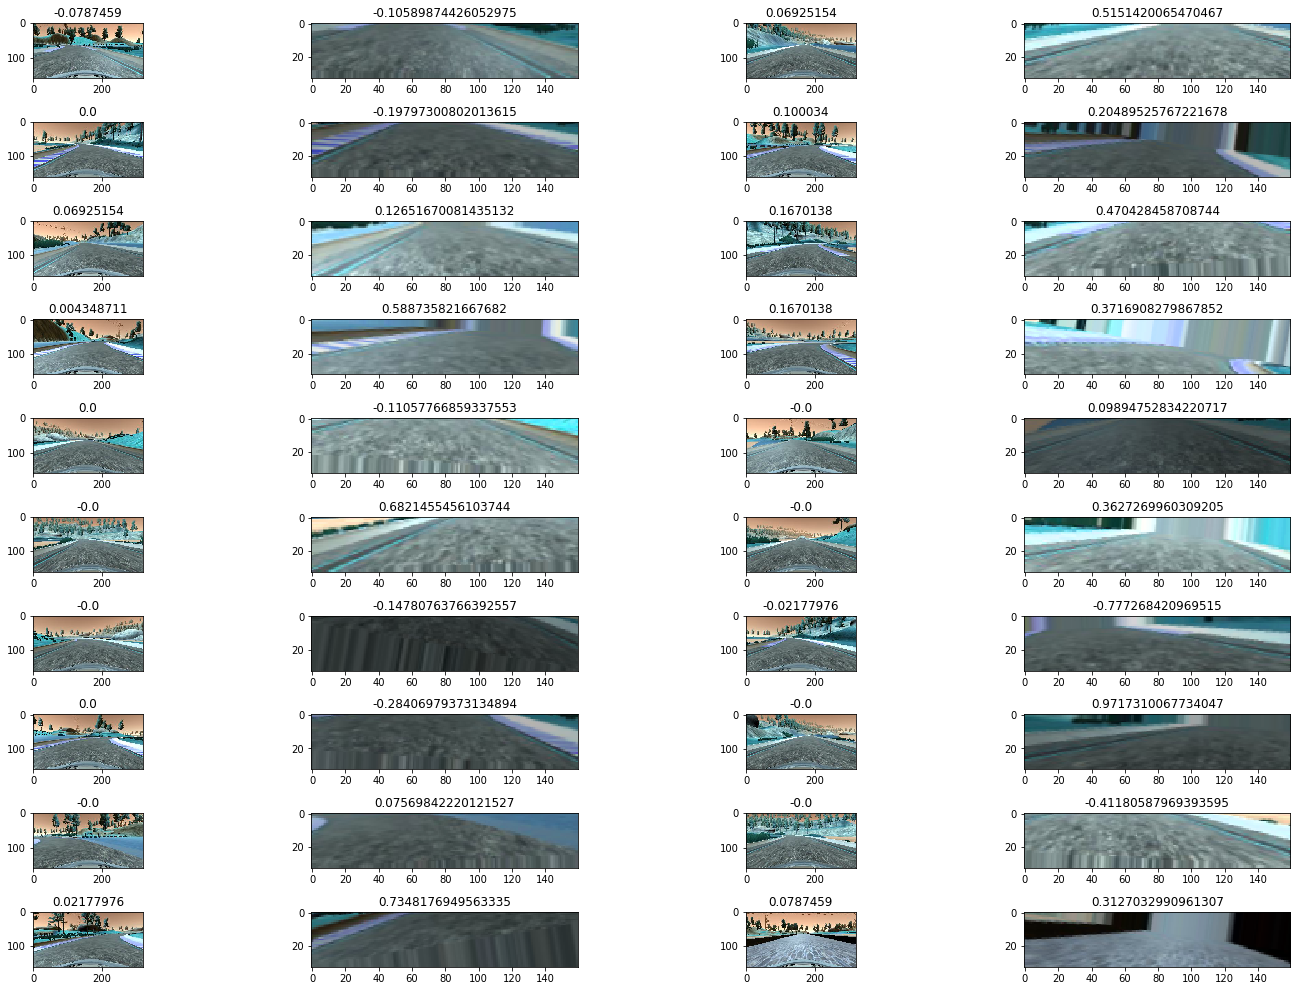

In [4]:
# displaying samples of 

i_st = random.randint(100, 3000)

data_pl = data[i_st:i_st+20]
print (len(data_pl), " :: rows")
images, steers = extract_samples_from_rows(data_pl, fake=False, augment=True)

change_settings(
    DO_FILTER = False
)

# Image augmentations effects visualization

fig = plt.figure(figsize=(20, 15))

for i, el in enumerate(zip(images, steers)):
    img, angle = el
    a=fig.add_subplot(len(images)//4+1,4,(i+1))
    imgplot = plt.imshow(img)
    a.set_title(str(angle))
plt.tight_layout()

In [5]:
import pandas as pd
column_names = ['center', 'left', 'right',
                'steering', 'throttle', 'brake', 'speed']
data_df = pd.read_csv('data/data_ori/driving_log.csv', skiprows=[0], names=column_names)
data_df.iloc[:5]

data_df['steering'][:5]


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: steering, dtype: float64

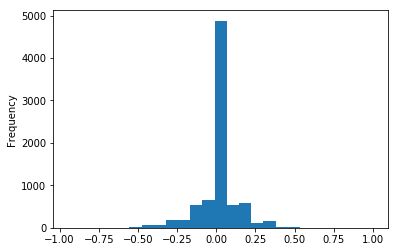

In [6]:
import matplotlib.pyplot as plt
#plt.figure()
#data_df['steering'].plot.figure()
data_df['steering'].plot.hist(bins=25)
plt.show()

In [4]:

from model import simple_model

model_t = simple_model()

model_t.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
cropping2d_2 (Cropping2D)        (None, 70, 320, 3)    0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 66, 316, 6)    456         cropping2d_2[0][0]               
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 22, 105, 6)    0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [6]:
epochs = 10


training_samples, training_sample_size, validation_samples, validation_sample_size = get_data(split_valid=0.2)

train_gen = generate_batch(training_samples)
validation_gen = generate_batch(validation_samples, augment=False, flipit=True)

print ("training {} samples.".format(training_sample_size))
print ("validating {} samples.".format(validation_sample_size))


flipping is set to True
extracted 138 samples from track1.
extracted 16072 samples from data_ori.
0 samples dropped based on 00 rules
extracted 16210 samples total.
training 12968 samples.
validating 3242 samples.


In [ ]:
history_object = model_t.fit_generator(train_gen, samples_per_epoch=training_sample_size,
                                         nb_epoch=epochs,
                                         validation_data=validation_gen,
                                         nb_val_samples=validation_sample_size,)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")

# saving history object
import pickle
with open('history.pk', 'wb') as handle:
    pickle.dump(history_object.history, handle, protocol=pickle.HIGHEST_PROTOCOL)